In [1]:
%load_ext autoreload
%autoreload 2

import dataset
from model import BioFace_FCN
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import separate_and_scale_output
from setup import setup
from decoder import ModelBasedDecoder
from loss import bioface_loss
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = setup()
celebA50k = dataset.CelebA50k("data/celebA50k.hdf5")
loader = torch.utils.data.DataLoader(celebA50k, batch_size=64, shuffle=True, drop_last=True)

model = BioFace_FCN([32,64,128,256,512])
model.to(device)
decoder = ModelBasedDecoder(params)
decoder.to(device)

celebA_avgImg = torch.tensor([129.1863,104.7624,93.5940]).cuda()
mu_image = torch.reshape(celebA_avgImg,(1,3,1,1))

#definitely not best optimizer, paper uses this due to autonn matlab limiations most likely
optim = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)



(99, 2)


In [2]:
total_start_time = time.time()
for epoch in range(10):  #PAPER DID 200 EPOCHS
    epoch_start_time = time.time()
    Bio_losses = []
    i = 0

    for batch, x in enumerate(loader):
        optim.zero_grad()
        i += 1
        x = x.to(device)
        x_img, x_mask, x_shading = x[:,0:3,:,:], x[:,6:7,:,:], x[:,3:6,:,:]

        #TRAINABLE ENC/DEC setup
        z,p = model(x_img)
        #seperating maps and scaling
        weightA,weightD,CCT,Fweights,b,bGrid,fmel,fblood,predictedShading,specmask = separate_and_scale_output(z,p)
        #Physics-Based Decoder
        sRGBim, specularities = decoder(weightA,weightD,CCT,Fweights,b,bGrid,fmel,fblood,predictedShading,specmask)
        
        #CONSIDER MOVING LOSS TO DEVICE
        loss = bioface_loss(sRGBim, x_img, x_mask, x_shading, specularities, predictedShading, b, mu_image)
        loss.backward()
        optim.step()

        if i%100 == 0:
            print('[Epoch %d] %d/%d' % (epoch, i*64,len(celebA50k)))
            print('Elapsed Time since Epoch Started: %f' % (time.time()-epoch_start_time))

    




/home/fzbuzz/anaconda3/envs/deep_learning/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
[Epoch 0] 6400/50765
Elapsed Time since Epoch Started: 36.637506


KeyboardInterrupt: 

In [2]:
# TIME TEST HERE

start_time = time.time()
i = 0

for batch, x in enumerate(loader):
    i += 1
    optim.zero_grad()
    x = x.to(device)
    x_img, x_mask, x_shading = x[:,0:3,:,:], x[:,6:7,:,:], x[:,3:6,:,:]

    #TRAINABLE ENC/DEC setup
    z,p = model(x_img)
    model_time = time.time()
    print('model enc/dec time: %f' % (model_time-start_time))
    #seperating maps and scaling
    scale_time = time.time()
    weightA,weightD,CCT,Fweights,b,bGrid,fmel,fblood,predictedShading,specmask = separate_and_scale_output(z,p)
    print('seperate and scale output time: %f' % (scale_time - model_time))
    #Physics-Based Decoder
    sRGBim, specularities = decoder(weightA,weightD,CCT,Fweights,b,bGrid,fmel,fblood,predictedShading,specmask)
    print('Physics-Based Decoder time: %f' %(time.time()-scale_time))

    break


model enc/dec time: 0.445465
seperate and scale output time: 0.000091
Physics-Based Decoder time: 0.015036
/home/fzbuzz/anaconda3/envs/deep_learning/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


(99, 2)


ModelBasedDecoder()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([64, 10, 64, 64])
torch.Size([10, 64, 64])
torch.Size([3, 64, 64])


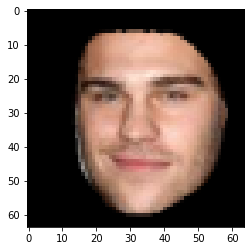

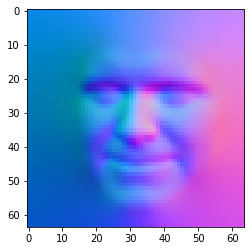

In [3]:
import dataset
from model import BioFace_FCN
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

celebA50k = dataset.CelebA50k("data/celebA50k.hdf5")
loader = torch.utils.data.DataLoader(celebA50k, batch_size=64, shuffle=True, drop_last=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for n, x in enumerate(loader):
    print(x.shape)
    print(x[0].shape)
    img, mask, shading = x[0,0:3,:,:], x[0,6:7,:,:], x[0,3:6,:,:]
    print(img.shape)
    plt.imshow((np.moveaxis(np.multiply(img,mask).numpy(),0,-1)))
    plt.show()
    plt.imshow((np.moveaxis(shading.numpy(),0,-1)))
    plt.show()
    break



In [4]:

model = BioFace_FCN([32,64,128,256,512])
model.to(device)



BioFace_FCN(
  (down_blocks): ModuleList(
    (0): TripleBlock(
      (blocks): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
    )
    (1): TripleBlock(
      (blocks): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, k

In [8]:
from helper_functions import separate_and_scale_output
from setup import setup

x = x.to(device)
x_img, x_mask, x_shading = x[:,0:3,:,:], x[:,6:7,:,:], x[:,3:6,:,:]


z,p = model(x_img)
weightA,weightD,CCT,Fweights,b,bGrid,fmel,fblood,predictedShading,specmask = separate_and_scale_output(z,p)



In [9]:
from decoder import ModelBasedDecoder
params = setup()
decoder = ModelBasedDecoder(params)

(99, 2)


In [12]:
sRGBim, specularities = decoder(weightA,weightD,CCT,Fweights,b,bGrid,fmel,fblood,predictedShading,specmask)

/home/fzbuzz/anaconda3/envs/deep_learning/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [18]:
celebA_avgImg = torch.tensor([129.1863,104.7624,93.5940]).cuda()
# mu_image = np.resize(celebA_avgImg, (1,1,3,1))
mu_image = torch.reshape(celebA_avgImg,(1,3,1,1))



In [21]:
from loss import bioface_loss

loss = bioface_loss(sRGBim, x_img, x_mask, x_shading, specularities, predictedShading, b, mu_image)

In [23]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


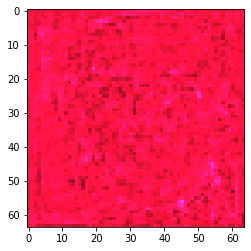

In [16]:
out = sRGBim.cpu().detach().numpy()
plt.imshow((np.moveaxis(np.multiply(out[0],mask).numpy(),0,-1)))
plt.imshow((np.moveaxis(out[0],0,-1)))

plt.show()

In [ ]:
# FULL TRAIN LOOP

